# cml1 - Immobilienrechner
# 2.1 Einfache lineare Regression und Residuenanalyse

Verwende ein einfaches lineares Modell zur Vorhersage von `price_cleaned` mit dem Attribut `Space extracted` oder `Floor_space_merged` (es gibt einige, wo beide fehlen (um die 800, können ignoriert werden).

Entwickle das Modell in einem Notebook. Untersuche dabei ob die Annahmen eines linearen Modells erfüllt sind mit geeigneten Darstellungen. Wie können Variablen-Transformationen verwendet werden, um die Modellvoraussetzungen besser zu erfüllen und das Modell zu verbessern?

Rapportiere und diskutiere die erreichte Genauigkeit der Vorhersage mit mehreren sinnvollen Metriken und auf unabhängigen Testdaten.

## Daten einlesen

Wir haben im Notebook "datawrangling.ipynb" den Datensatz bereinigt und lesen dieser hier ein. Die Aufgabe dieses Notebooks ist es, ein einfaches lineares Modell zu erstellen, um Vorhersagen von `price_cleaned` mit dem Attribut `Space extracted` oder `Floor_space_merged` zu machen. In unserem Fall ist der Attribut `Living_area_unified`, da wir alle "Nutzfläche" Variablen zusammengefasst haben.

<b>Achtung:</b> Im Datawrangling Notebook haben wir Space extracted zu `Living_area_unified` zusammengefasst. Anstelle hier also wie in der Aufgabenstellung `Space extraced` zu wählen, arbeiten wir mit `Living_area_unified`. <br>
Genauso gemerged ist `Floor_space_merged` wir nutzen hier `Floor space`

In [222]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.impute import SimpleImputer
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import MinMaxScaler, StandardScaler
import xgboost as xgb

df = pd.read_csv('../data/immo_data_clean.csv', low_memory=False)

print(df.shape)

(21466, 47)


In [223]:
# Separate numerical and categorical columns
numerical_cols = df.select_dtypes(include=['float64', 'int64']).columns
categorical_cols = df.select_dtypes(include=['object']).columns

# df without categorical columns
df_num = df.drop(categorical_cols, axis=1)

In [224]:
# Check missing values of feature columns
df_num[['Living_area_unified','Floor space']].isnull().sum().sort_values(ascending=False)


Floor space            18692
Living_area_unified      903
dtype: int64

Der Output von oben Zeigt uns: Floor space hat extrem viele fehlende Werte. Eine "einfache" lineare Regression würde hier nicht funktionieren wenn wir nur die Werte entfernen bei denen beide Fehlen.  <br>
Die Optionen die wir nun haben sind folgende: <br>
<ul>
<li>Wir verwenden nur `Living_area_unified` und rechnen unser Modell so - (2.1.1)</li>
<li>Wir ersetzen Fehlende `Floor space` values mit `Living_area_unified` - (2.1.2)</li>
<li>Wir ersetzen Fehlende `Living_area_unified` values mit `Floor space`- (2.1.3)</li>
<li>Wir versuchen anhand der beiden Features ein neues Feature zu generieren das anstelle `Floor space` verwendet wird.- (2.1.4)</li>
<li>Wir verwenden ein nicht lineares Modell, welches dann aber nicht mehr der Aufgabenstellung für 2.1 entspricht</li>
</ul>

In [225]:
# check where both columns are missing
df_num[(df_num['Living_area_unified'].isnull()) & (df_num['Floor space'].isnull())].shape

(711, 44)

Dieser Ouput oben zeigt die in der Aufgabenstellung angekündigten ca. 800 Fehlenden Werte beider Features.

In [226]:
# drop rows where both columns are missing
df_num = df_num.dropna(subset=['Living_area_unified','Floor space'], how='all')
df_num[(df_num['Living_area_unified'].isnull()) & (df_num['Floor space'].isnull())].shape

(0, 44)

In [227]:
df_num211 = df_num.copy()
df_num212 = df_num.copy()
df_num213 = df_num.copy()
df_num214 = df_num.copy()

Wie in der Aufgabenstellung beschrieben werden diese nun für diese Modelle ignoriert.

## 2.1.1 Einfache lineare Regression und Residuenanalyse

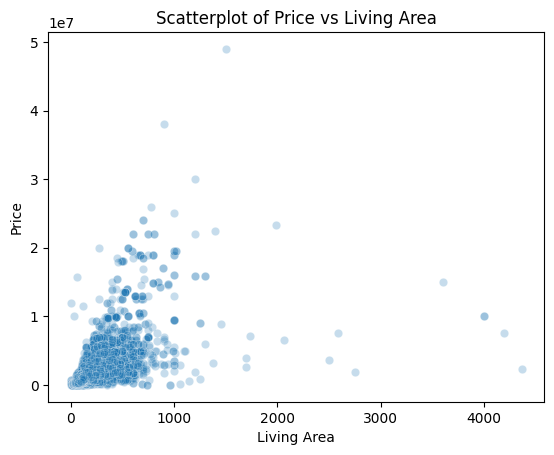

In [228]:
# subset dataset
df_num211 = df_num211[['Living_area_unified', 'price_cleaned']]

# drop na values
df_num211 = df_num211.dropna(subset=['Living_area_unified'])

# split dataset
X = df_num211['Living_area_unified']
y = df_num211['price_cleaned']

sns.scatterplot(data=df_num211, x=X, y=y, alpha=0.25)
plt.title('Scatterplot of Price vs Living Area')
plt.ylabel('Price')
plt.xlabel('Living Area')
plt.show()

Anhand des Scatterplots sehen wir keine grosse Korrelaiton zwischen dem Preis und der Nutzfläche. Wir werden trotzdem eine lineare Regression durchführen, um die Residuen zu analysieren.

Erstellen wir nun eine Funktion, bei der wir verschiedene Modelle erstellen können. Die Funktion wird folgendermassen gestaltet:

Eingabe:
1. $X$ (Feature-Daten)
2. $y$ (Zielvariable)
3. Eine Transformationsfunktion (optional), die auf $X$ angewendet wird, bevor die Regression durchgeführt wird.

Ausgabe:
1. Ein Plot mit drei Subplots: "Actual vs Predicted Price", "Residuals" und "Residuals Histogram".

In [229]:
def perform_linear_regression(X, y, transformation_func=None):
    # Apply transformation if provided
    if transformation_func:
        X = transformation_func(X)
    
    # Split dataset
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    # Train linear regression model
    lin_reg = LinearRegression()
    if len(X_train.shape) == 1:
        lin_reg.fit(X_train.values.reshape(-1, 1), y_train)
        y_pred = lin_reg.predict(X_test.values.reshape(-1, 1))
    else:
        lin_reg.fit(X_train, y_train)
        y_pred = lin_reg.predict(X_test)
    r2 = r2_score(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    # Plotting
    fig, ax = plt.subplots(1, 3, figsize=(16, 6))
    
    # Actual vs Predicted plot
    sns.regplot(x=y_test, y=y_pred, scatter_kws={'alpha': 0.1}, ax=ax[0])
    ax[0].set_title(f'Actual vs Predicted Price - R2: {r2:.4f} - MSE: {mse:.4f}')
    ax[0].set_xlabel('Actual Price')
    ax[0].set_ylabel('Predicted Price')

    # Residuals plot
    sns.residplot(x=y_test, y=y_pred, scatter_kws={'alpha': 0.1}, ax=ax[1])
    ax[1].set_title('Residuals')
    ax[1].set_xlabel('Actual Price')
    ax[1].set_ylabel('Residuals')

    # Histogram plot
    sns.histplot((y_test - y_pred), ax=ax[2])
    ax[2].set_title('Residuals Histogram')
    ax[2].set_xlabel('Residuals')
    ax[2].set_ylabel('Frequency')
    
    plt.show()


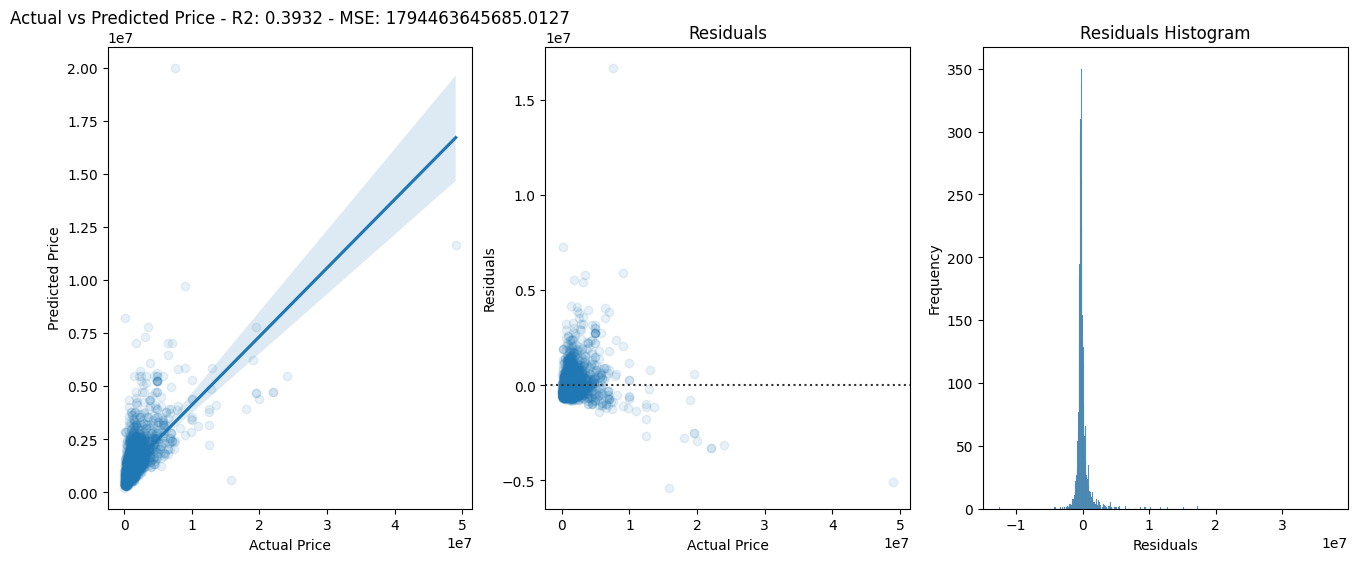

In [230]:
# Linear regression without transformation
perform_linear_regression(X, y, None)

Es ist gut zu sehen, dass das Modell sehr schlecht ist. 
- $R^2$ ist sehr klein
- Die Residuen streuen sich nicht um den Erwartungswert 0.
- Die Residuen sind recht normalverteilt, aber es gibt sehr grosse Ausreisser.

Um das Modell zu verbessern, werden wir die X-Variablen-Transformation machen.
- Log
- Quadrat
- Quadratwurzel

### Log-Transformation

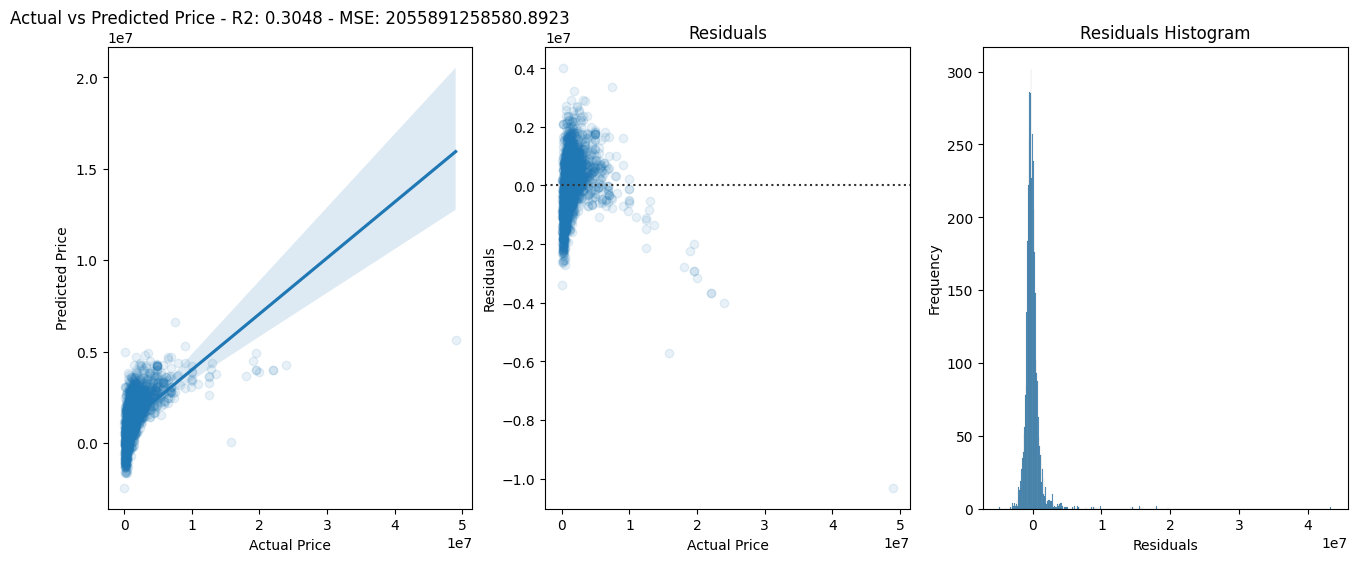

In [231]:
perform_linear_regression(X, y, transformation_func=np.log)

### Quadrat-Transformation

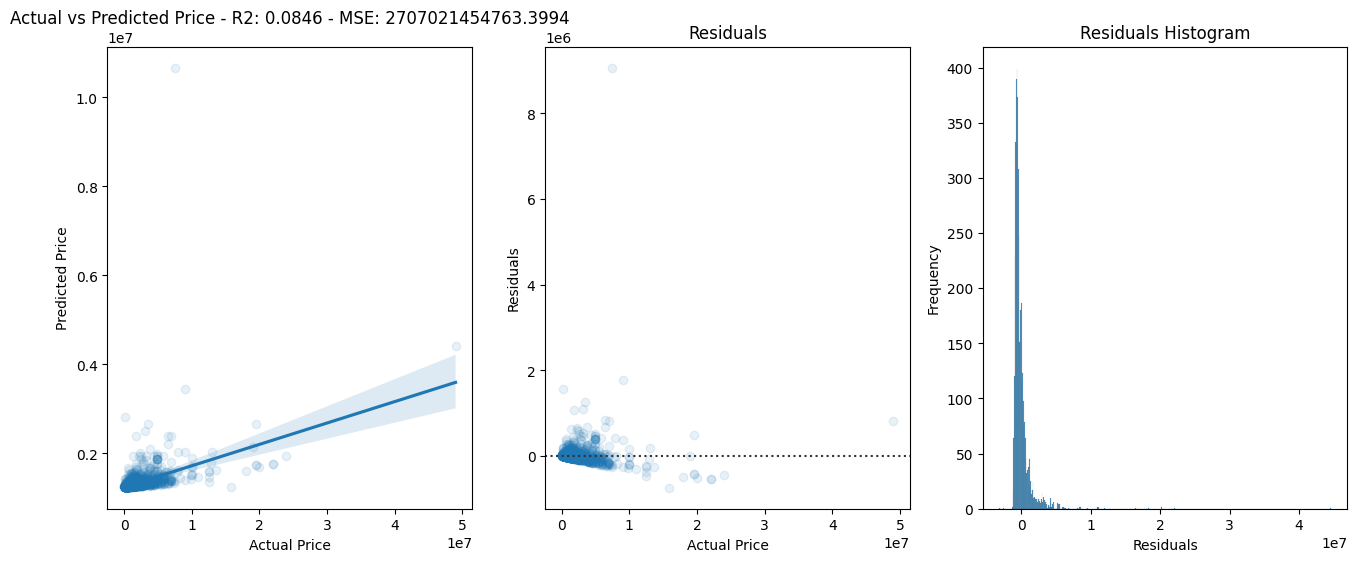

In [232]:
perform_linear_regression(X, y, transformation_func=np.square)

### Quadratwurzel-Transformation

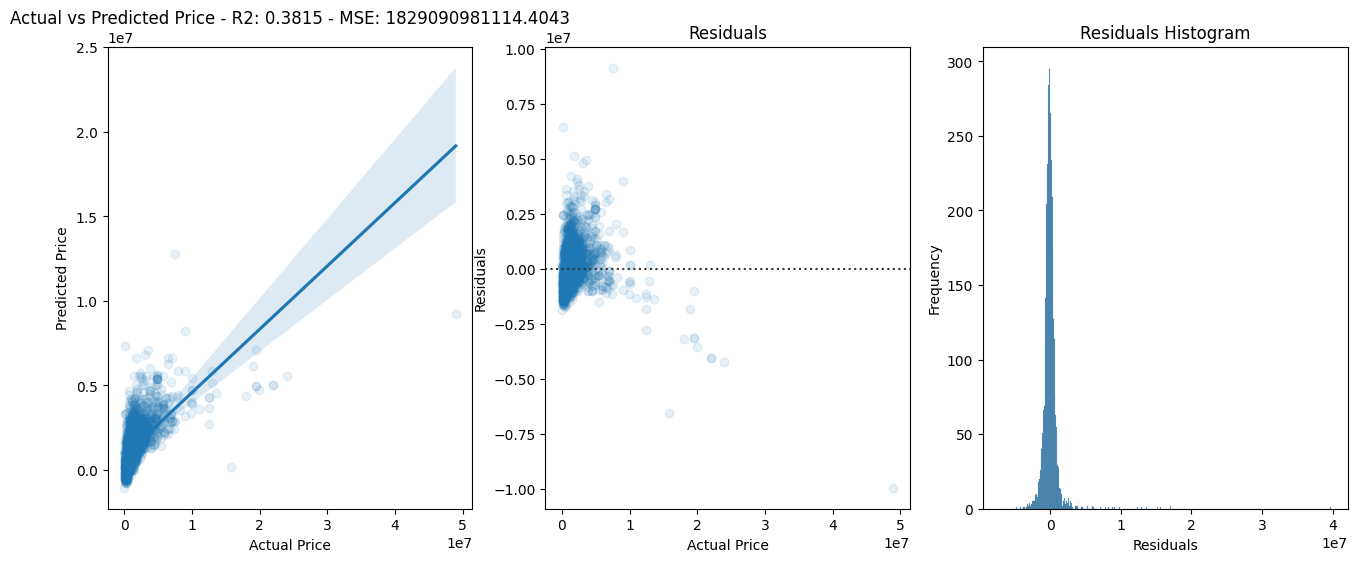

In [233]:
perform_linear_regression(X, y, transformation_func=np.sqrt)

## 2.1.2 Replacing missing Floor space

Diese Übung ist offensichtlich (19'000+ NA Values) ein eher schlechter Ansatz, da wir hier die meisten Werte ersetzen bzw. mit Floor space füllen. Im Sinne der Experimente, führen wir das aber trotzdem druch.

In [234]:
# Replacing missing 'Floor space' values with 'Living_area_unified' values
df_num212['Floor space'] = df_num212['Floor space'].fillna(df_num212['Living_area_unified'])
# subset dataset
df_num212 = df_num212[['Floor space','price_cleaned']]

# drop na values
df_num212 = df_num212.dropna(subset=['Floor space'])

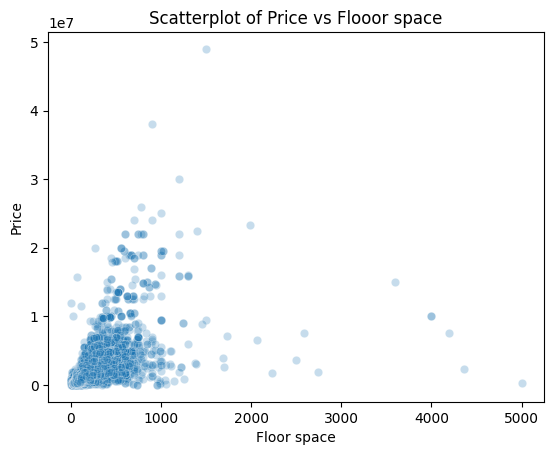

In [235]:
# split dataset
X2 = df_num212['Floor space']
y2 = df_num212['price_cleaned']

sns.scatterplot(data=df_num212, x=X2, y=y2, alpha=0.25)
plt.title('Scatterplot of Price vs Flooor space')
plt.ylabel('Price')
plt.xlabel('Floor space')
plt.show()

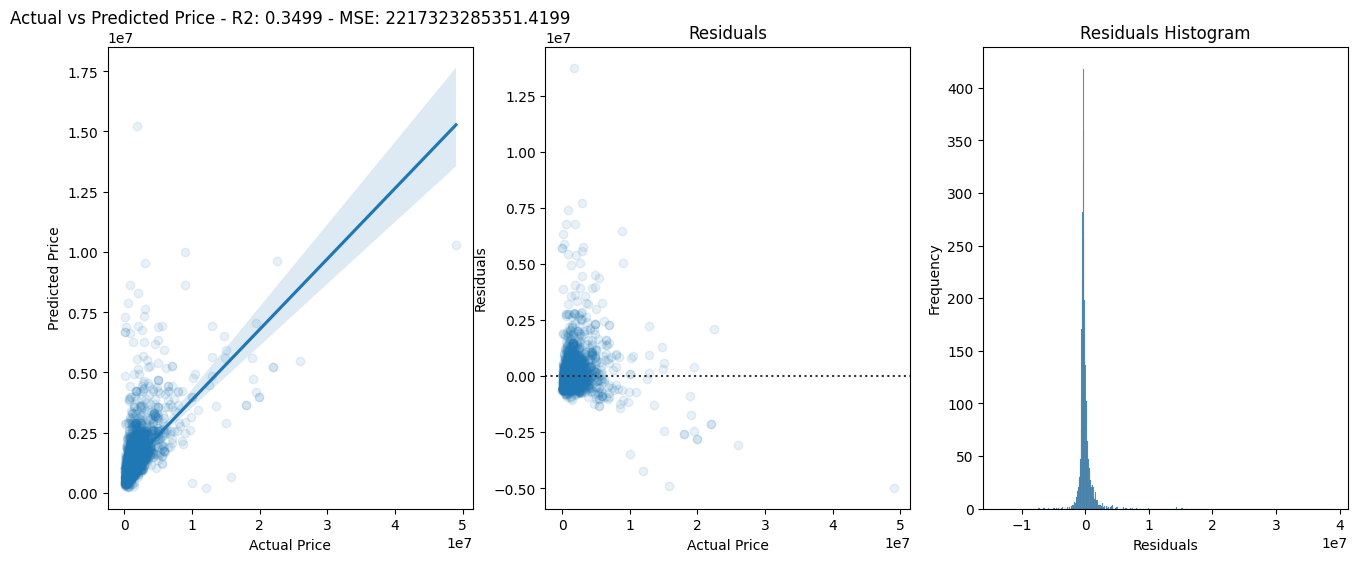

In [236]:
# Linear regression without transformation
perform_linear_regression(X2, y2, None)

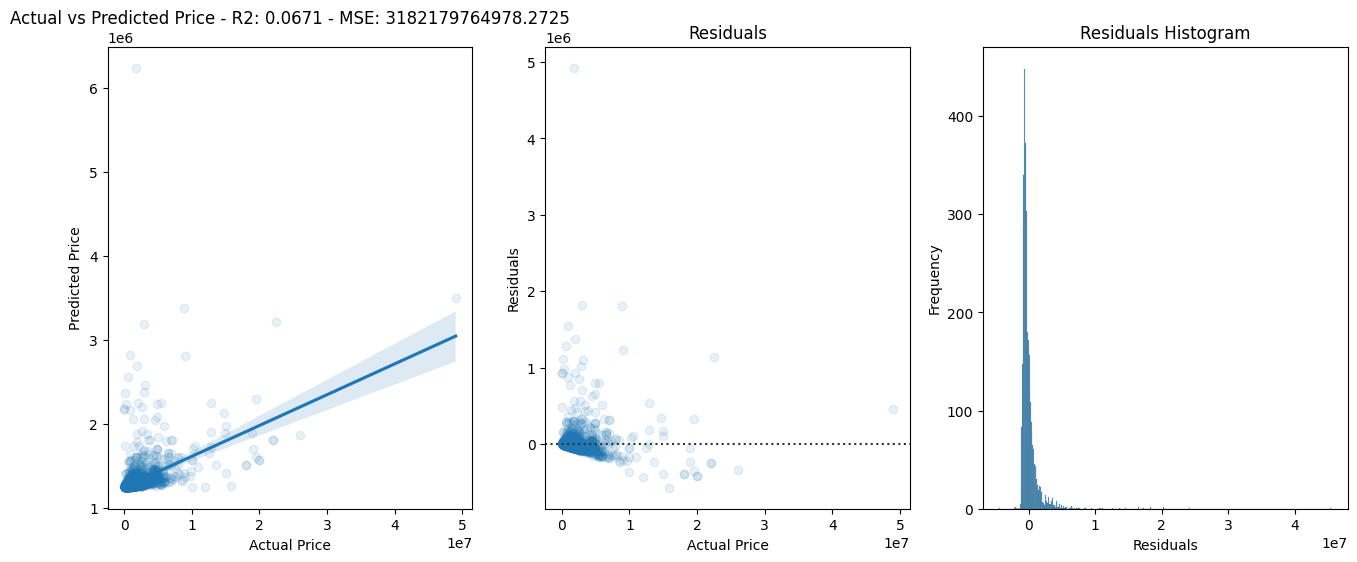

In [237]:
perform_linear_regression(X2, y2, transformation_func=np.square)

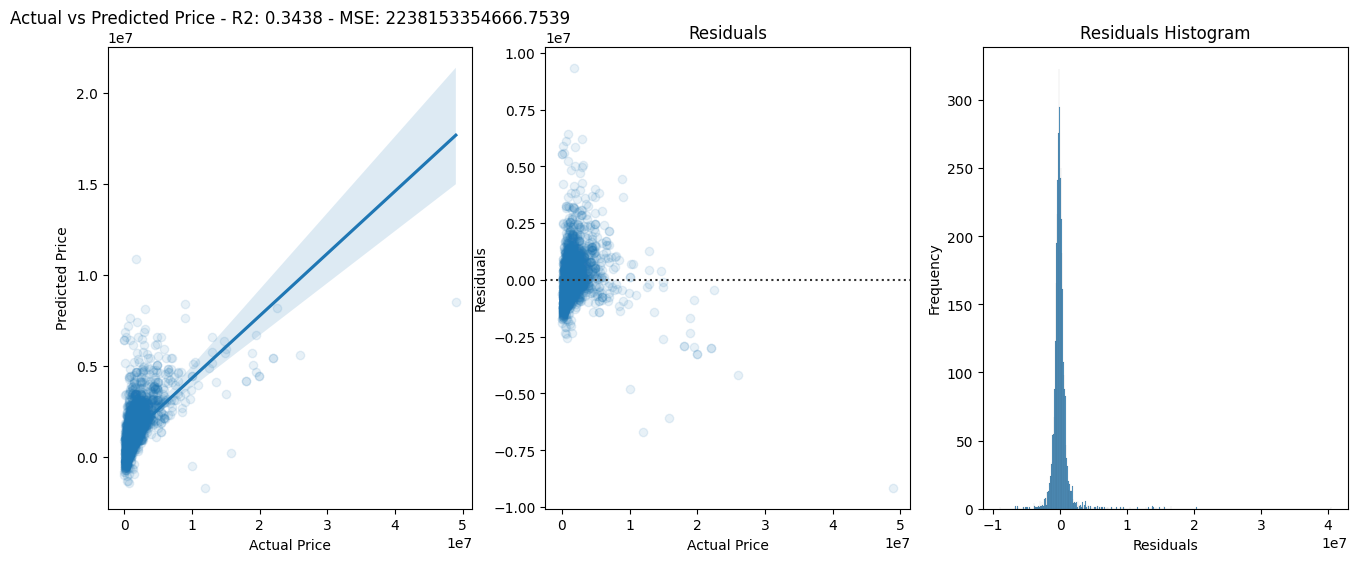

In [238]:
perform_linear_regression(X2, y2, transformation_func=np.sqrt)

Wie wir sehen sind die Modelle minimal besser aber immer noch sehr schlecht.

## 2.1.3 Replacing missing Living_area_unified

In [239]:
# Replacing missing 'Living_area_unified' values with 'Floor space' values 
df_num213['Living_area_unified'] = df_num213['Living_area_unified'].fillna(df_num213['Floor space'])
# subset dataset
df_num212 = df_num213[['Living_area_unified','price_cleaned']]

# drop na values
df_num212 = df_num213.dropna(subset=['Living_area_unified'])

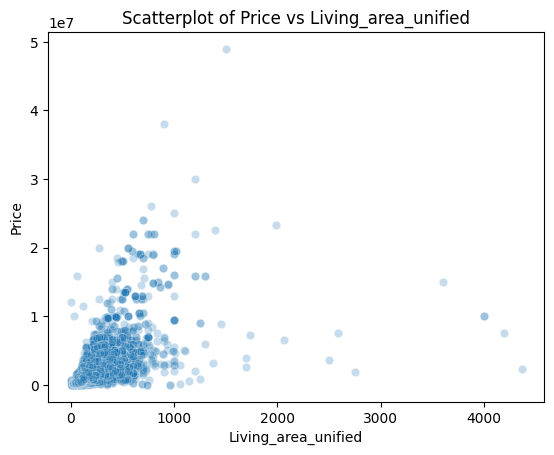

In [240]:
# split dataset
X3 = df_num213['Living_area_unified']
y3 = df_num213['price_cleaned']

sns.scatterplot(data=df_num213, x=X3, y=y3, alpha=0.25)
plt.title('Scatterplot of Price vs Living_area_unified')
plt.ylabel('Price')
plt.xlabel('Living_area_unified')
plt.show()

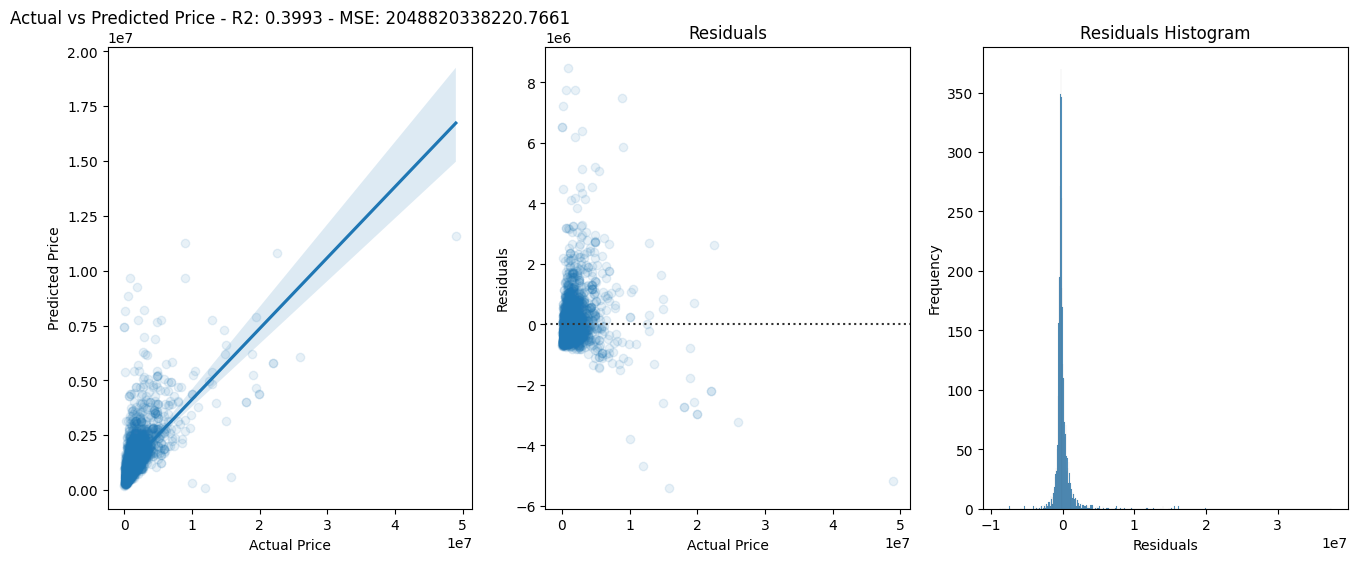

In [241]:
# Linear regression without transformation
perform_linear_regression(X3, y3, None)

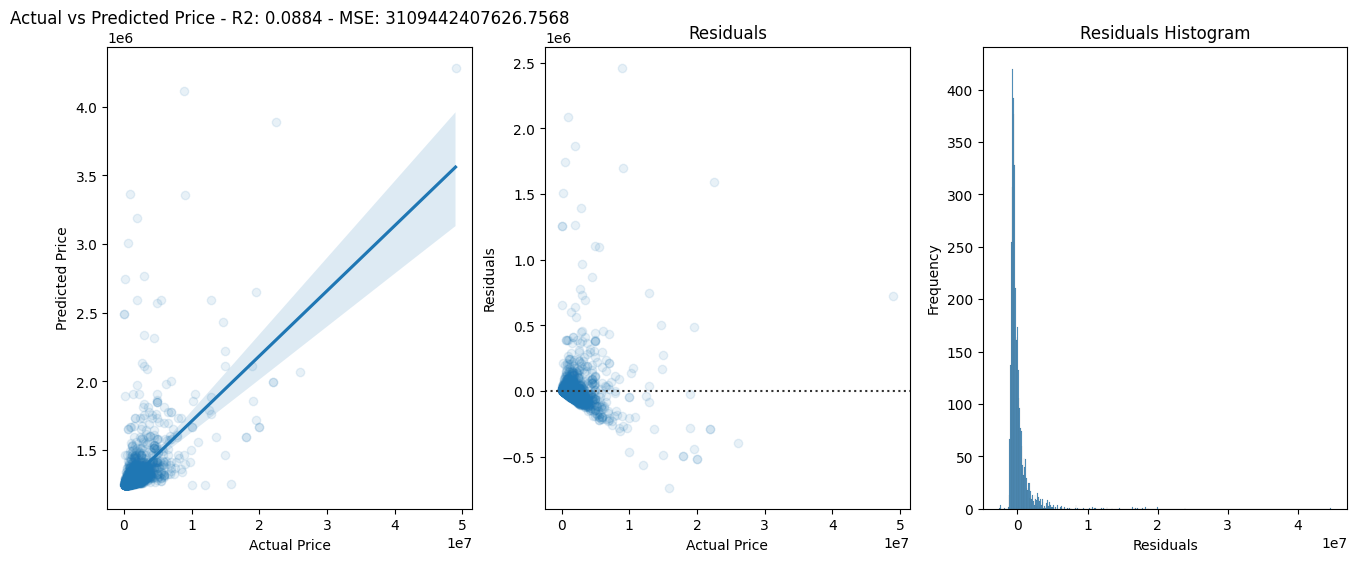

In [242]:
perform_linear_regression(X3, y3, transformation_func=np.square)

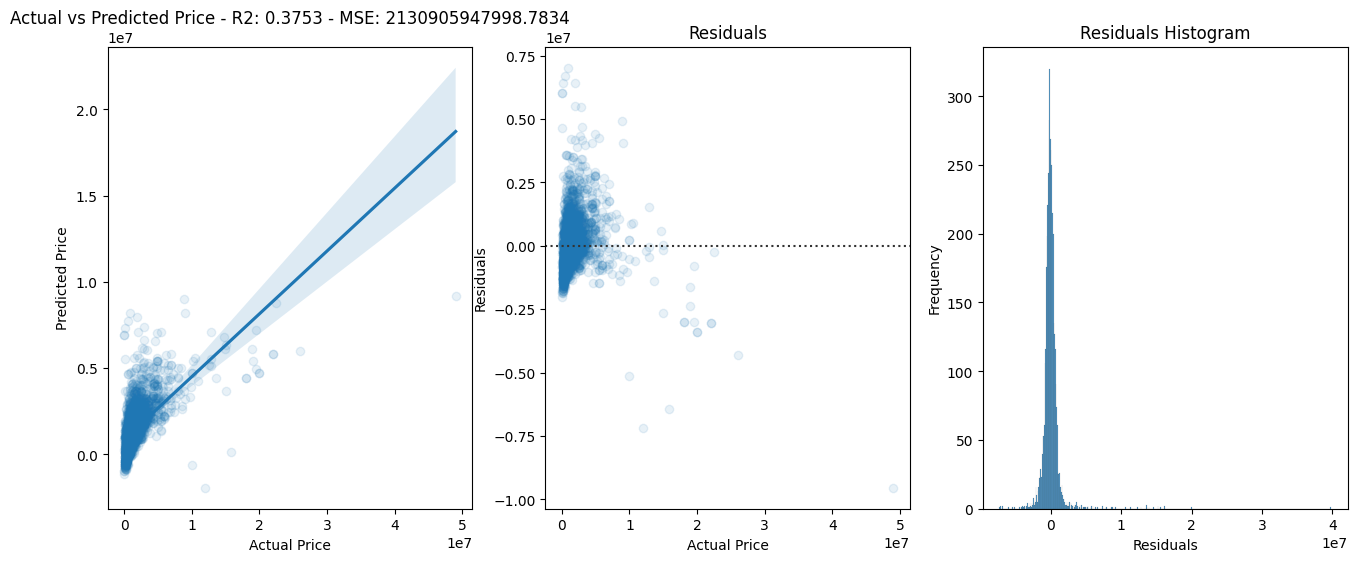

In [243]:
perform_linear_regression(X3, y3, transformation_func=np.sqrt)

## 2.1.4 Feature Engineering

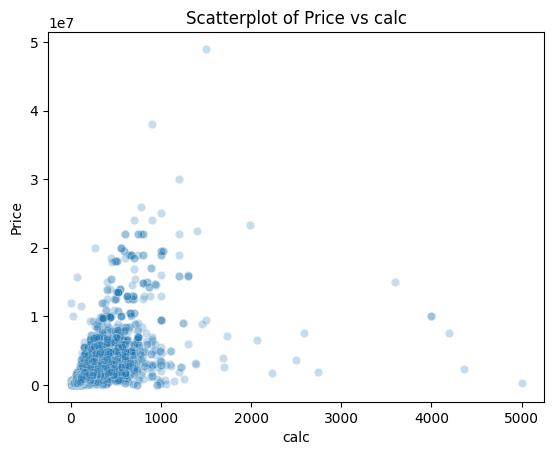

In [244]:
# make df_num214['calc']  whatever value is bigger of df_num214['Living_area_unified'] or df_num214['Floor space']
df_num214['calc'] = df_num214[['Living_area_unified', 'Floor space']].max(axis=1)
# subset dataset
df_num214 = df_num214[['calc','price_cleaned']]
# drop na values
df_num214 = df_num214.dropna(subset=['calc'])
# split dataset
X4 = df_num214['calc']
y4 = df_num214['price_cleaned']
sns.scatterplot(data=df_num213, x=X4, y=y4, alpha=0.25)
plt.title('Scatterplot of Price vs calc')
plt.ylabel('Price')
plt.xlabel('calc')
plt.show()

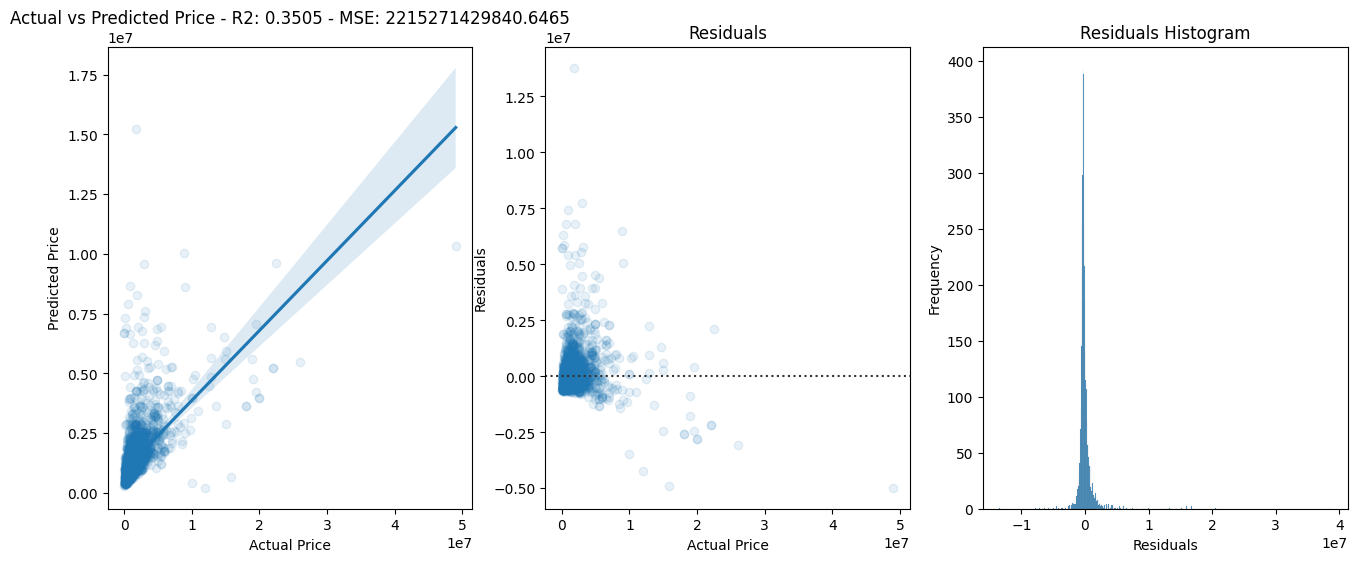

In [245]:
# Linear regression without transformation
perform_linear_regression(X4, y4, None)

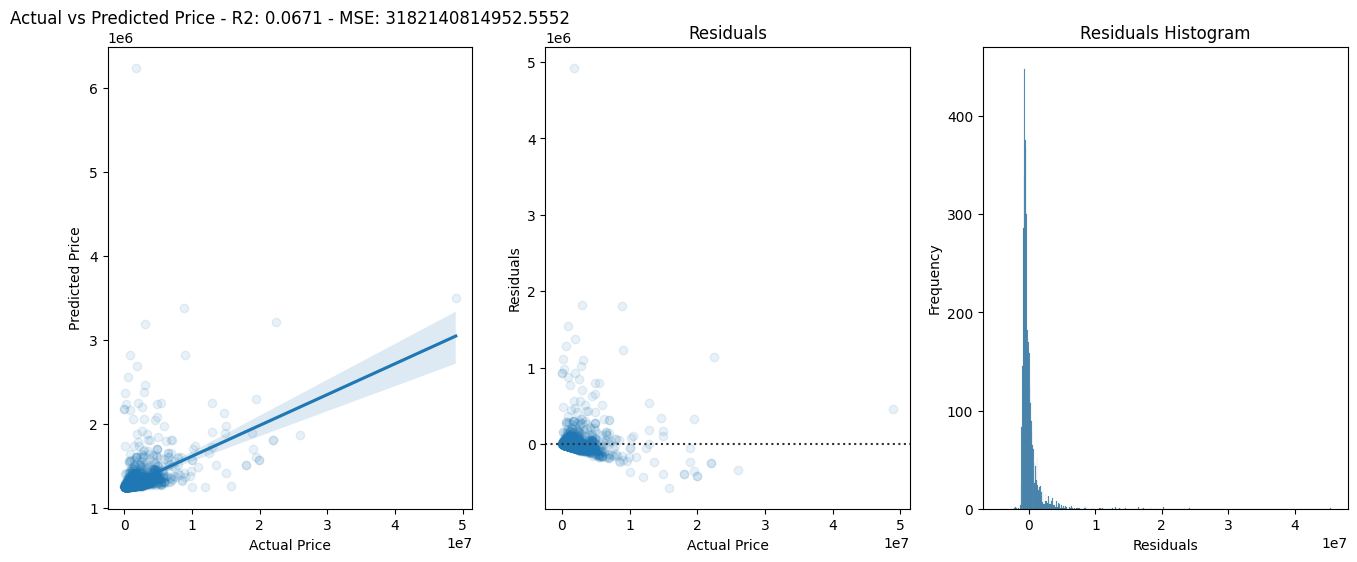

In [246]:
perform_linear_regression(X4, y4, transformation_func=np.square)

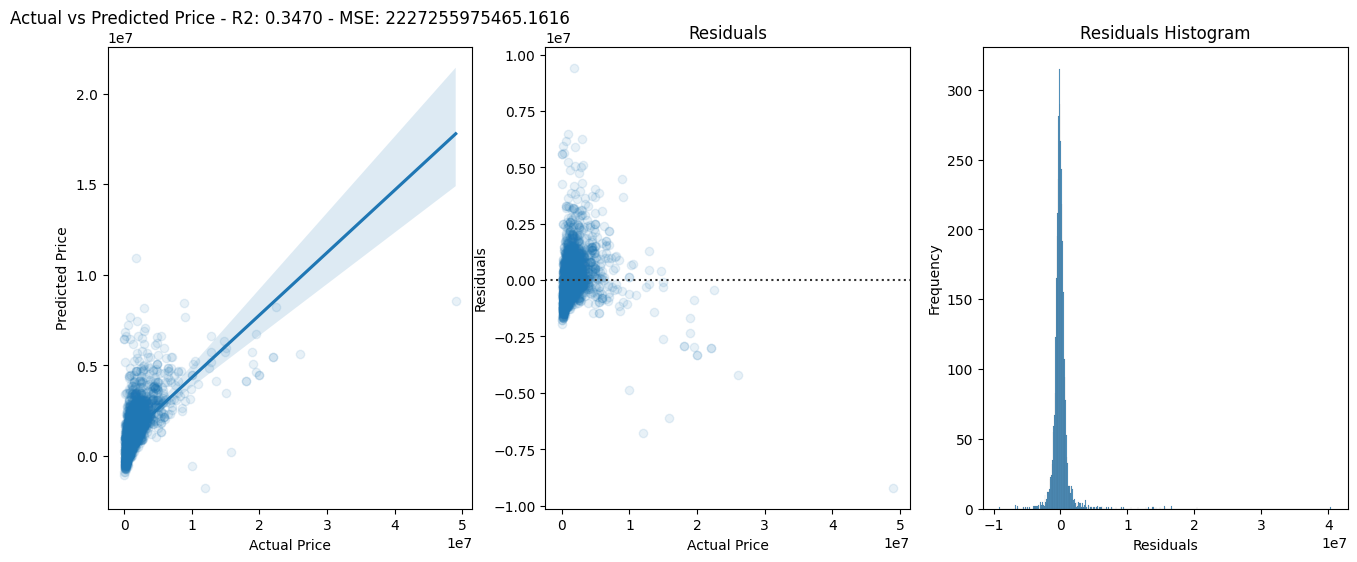

In [247]:
perform_linear_regression(X4, y=y4, transformation_func=np.sqrt)

## Bewertung

Alle Modelle waren schlecht. Das beste war aber von 2.1.3 somit versuchen wir dieses zu verbessern.

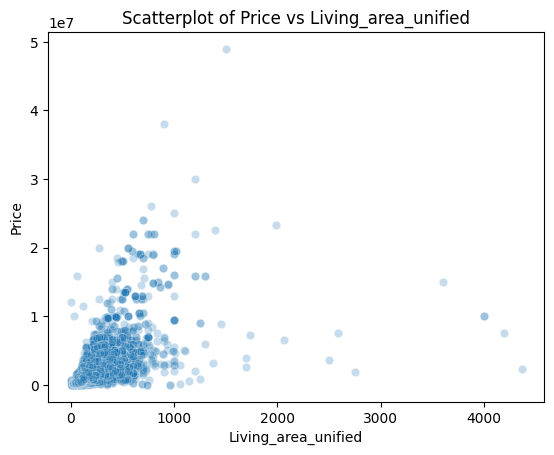

In [248]:
sns.scatterplot(data=df_num213, x=X3, y=y3, alpha=0.25)
plt.title('Scatterplot of Price vs Living_area_unified')
plt.ylabel('Price')
plt.xlabel('Living_area_unified')
plt.show()

Schauen wir uns den Scatterplot nochmals genauer an, fallen uns starke ausreisser auf. Wir werden diese einmal grob eliminieren.

In [267]:
# from df_num213 eliminate outliers
df_num2132 = df_num213[df_num213['Living_area_unified'] < 600]
df_num2132 = df_num2132[df_num2132['price_cleaned'] < 5000000]
X32 = df_num2132['Living_area_unified']
y32 = df_num2132['price_cleaned']


In [268]:
print(df_num2132.shape, df_num213.shape)

(20111, 44) (20755, 44)


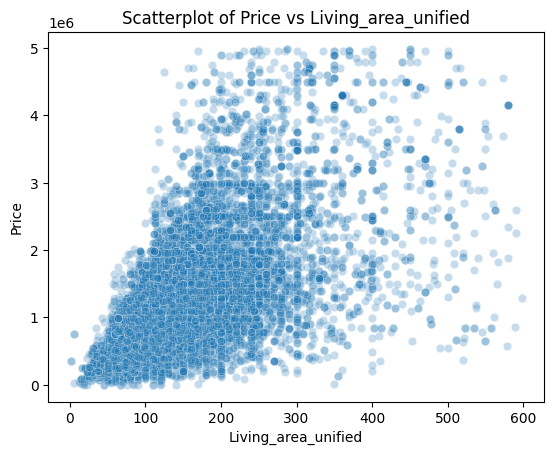

In [269]:
sns.scatterplot(data=df_num2132, x=X32, y=y32, alpha=0.25)
plt.title('Scatterplot of Price vs Living_area_unified')
plt.ylabel('Price')
plt.xlabel('Living_area_unified')
plt.show()

so sieht der Scatterplot bereits anders aus wie zuvor und wir haben nur einen Datenverlust von 2.5%

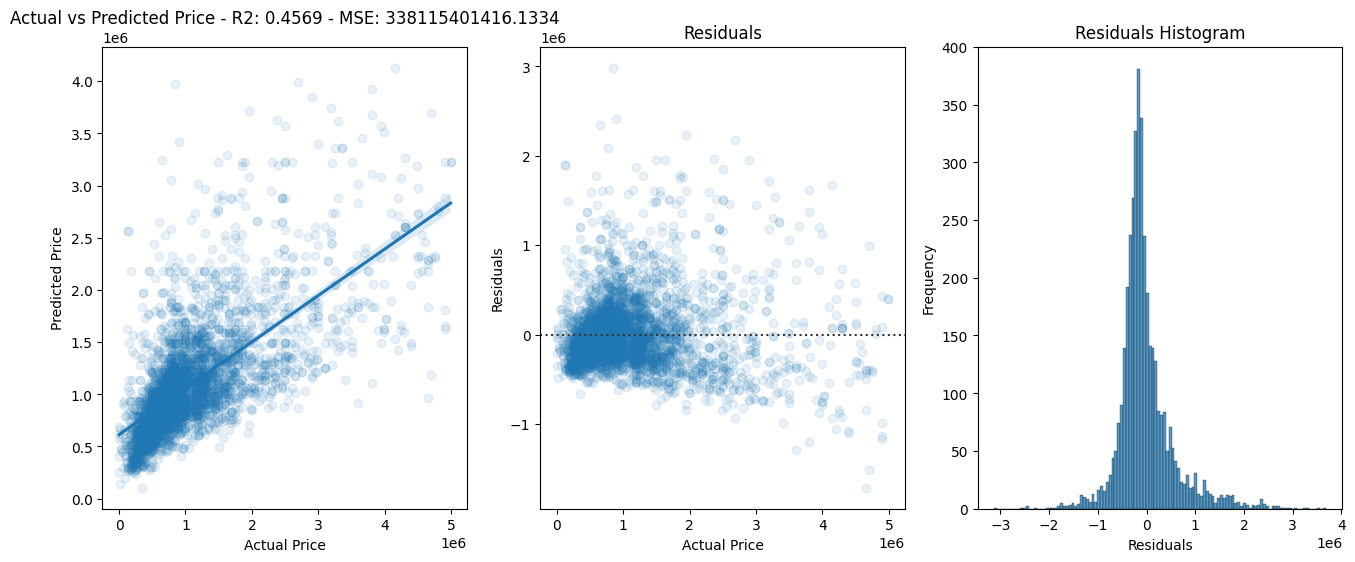

In [270]:
perform_linear_regression(X32, y32, None)

0.45 ist das beste was wir hier erzielen können. Die Residiuen Zeigen weiterhin, dass das Modell zu wenig komplex ist. Wir sind auf andere Modelle angewiesen und können uns nicht auf Lineare Regressions verlassen